In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

In [3]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
    for k, v in j['stats'].items():
        col[k] = v
    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    #col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    #col['digits_object'] = 1 - col['digits_entropy']
    #col['letters_object'] = 1 - col['letters_entropy']
    #col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    #col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

## Fix stride. vary nb of layers

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## Fix nb layers. Vary stride

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

In [ ]:
show(df)

# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [ ]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [4]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = df_full['recons'].fillna(0.0)

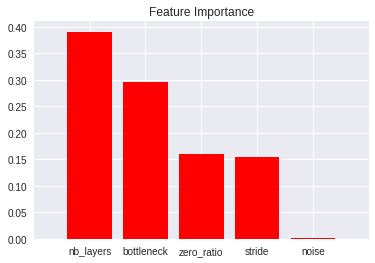

In [11]:
from scikitplot.estimators import plot_feature_importances
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg = GradientBoostingRegressor(n_estimators=30, max_depth=20)
reg.fit(x, y)
#reg.feature_importances_ = reg.coef_
plot_feature_importances(reg, feature_names=x.columns)

In [16]:
pd.DataFrame({'delta': np.abs(reg.predict(x)-y), 'y': y}).sample(10)

,delta,y
job_id,,
78d155d20b40759f2f5ac333aee1c616,0.004161,0.0040
ab45d34bd45790c492f913e11f28b1dd,0.000786,0.0836
9a6da4b02514b0828331badb37217bb7,0.004101,0.0054
7d308b4f1c92e8eb6ef26e03c8540032,0.006793,0.2624
fcfe73728bc4338ad48a0487eca9bd9c,0.010223,0.3433
67bf47b5fd9034643709629bde89041c,0.003650,0.0085
8ed4c929db06fb50bbe9c6723f153772,0.003601,0.0098
e611fba0dfcce6b264cfec8a32e6b5be,0.004025,0.0046
bd37901de050618165cd83355b7df1b4,0.003747,0.0129


In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

In [ ]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [19]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'recons',
    'ratio_unique'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,recons,ratio_unique
digits_count,1,-0.897334,0.504346,0.410802,0.0418502,0.47685,-0.00953573,0.252758
letters_count,-0.897334,1,-0.420536,-0.322768,0.0374954,-0.395098,0.0460488,-0.156755
digits_objectness,0.504346,-0.420536,1,0.921371,0.716197,0.956652,0.195174,0.903427
letters_objectness,0.410802,-0.322768,0.921371,1,0.832285,0.957296,0.389438,0.872042
digits_and_letters_objectness,0.0418502,0.0374954,0.716197,0.832285,1,0.74305,0.32728,0.830626
emnist_objectness,0.47685,-0.395098,0.956652,0.957296,0.74305,1,0.304504,0.866904
recons,-0.00953573,0.0460488,0.195174,0.389438,0.32728,0.304504,1,0.245437
ratio_unique,0.252758,-0.156755,0.903427,0.872042,0.830626,0.866904,0.245437,1


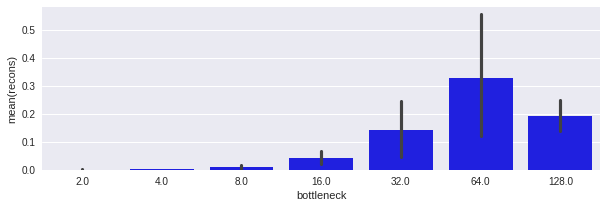

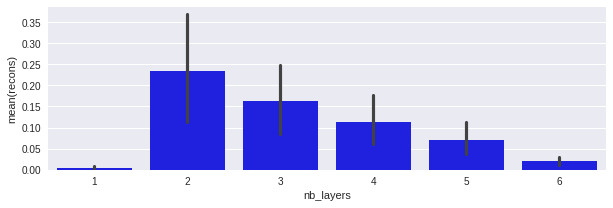

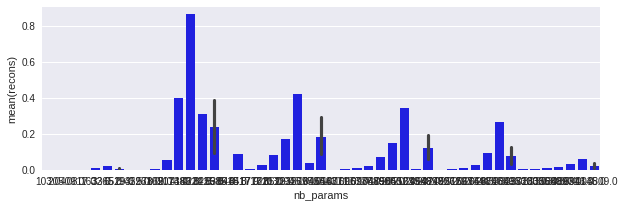

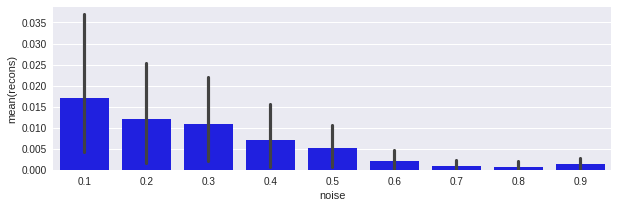

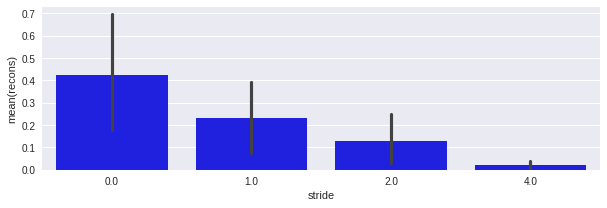

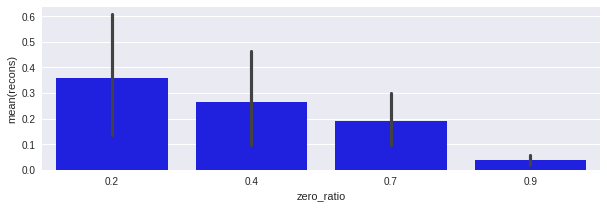

In [27]:
d = df_full
#d = df_full.fillna(-1)
#d = d[d['sampler']  == 'mnist_capacity']
ycols = ['recons']
xcols = ['bottleneck', 'nb_layers', 'nb_params', 'noise', 'stride', 'zero_ratio']
for xcol in xcols:
    for ycol in ycols:
        fig = plt.figure(figsize=(10, 3))
        sns.barplot(x=xcol, y=ycol, data=d, color='blue')
        plt.show()

In [26]:
d = df_full
d = d.sort_values(by='recons', ascending=False)
d.iloc[0:20]

,bottleneck,digits_and_letters_entropy,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_objectness,hwrt,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_objectness,nb_layers,nb_params,noise,ratio_unique,recons,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68d5ee04e4b8638c35f7024f07817250,128.0,0.055944,17.414164,0.254,7.918254e-01,0.147050,6.492082e+07,0.221,0.002000,4.463392,0.034,0.032,0.713,0.302965,0.138,6.574965,NaN,6.405925e-01,0.090156,27.442280,0.676,8.593861e-01,0.144903,1.426590e+08,0.542,0.002006,10.579434,2,825985.0,NaN,1.000,0.9323,mnist_deep,0.0,NaN
fcce855f0ae6a9391c25846ba8f922fd,128.0,0.289658,4.532099,0.082,5.460012e-01,0.317613,6.507256e+07,0.069,0.192666,2.338978,0.029,0.026,0.412,0.271371,0.079,2.681726,NaN,3.738036e-01,0.175185,5.693460,0.876,6.116427e-01,0.436177,1.428649e+08,0.344,0.192672,3.675390,2,825985.0,NaN,0.505,0.9185,mnist_deep_lifetime,NaN,0.2
4a4b3a3a4562d7102aceb49eab12c8c0,64.0,0.036291,15.993737,0.683,8.820552e-01,0.081740,6.480694e+07,0.618,0.002000,6.329883,0.068,0.063,0.638,0.252636,0.191,11.383430,NaN,7.903594e-01,0.104334,59.010303,0.260,9.265101e-01,0.107233,1.425919e+08,0.221,0.002006,14.428025,2,416321.0,NaN,1.000,0.8613,mnist_capacity,NaN,NaN
a167259933f54183c717cd4ed0529081,128.0,0.041000,18.065023,0.589,8.708652e-01,0.077320,6.481716e+07,0.537,0.002000,6.289638,0.098,0.089,0.579,0.234873,0.188,13.520828,NaN,7.949804e-01,0.108532,60.633957,0.330,9.268268e-01,0.109443,1.425949e+08,0.279,0.002006,14.407940,2,825985.0,NaN,1.000,0.8509,mnist_deep,1.0,NaN
9fac5b60f593b92c11133f9813f3c5a9,128.0,0.170560,10.294384,0.321,6.840247e-01,0.218601,6.494705e+07,0.290,0.060322,3.376249,0.099,0.097,0.457,0.266032,0.108,7.324684,NaN,5.907915e-01,0.149898,18.387068,0.644,7.510086e-01,0.264205,1.427253e+08,0.354,0.060328,6.982135,2,825985.0,NaN,0.759,0.7324,mnist_deep_lifetime,NaN,0.4
5511413bb44248b61f32518f638a8d9e,128.0,0.043103,15.068205,0.712,9.121210e-01,0.109552,6.482374e+07,0.621,0.002000,6.414445,0.031,0.029,0.694,0.310742,0.131,8.729666,NaN,6.468626e-01,0.100108,26.331829,0.231,9.171454e-01,0.121261,1.426300e+08,0.193,0.002006,13.536750,3,1645441.0,NaN,1.000,0.7190,mnist_deep,0.0,NaN
f316dedd30ebc5f51c4678f07979436c,128.0,0.031410,14.714568,0.773,9.241394e-01,0.083757,6.478472e+07,0.713,0.002000,6.948976,0.081,0.073,0.572,0.254680,0.178,12.290185,NaN,7.754346e-01,0.104893,55.180447,0.172,9.265543e-01,0.101766,1.426092e+08,0.153,0.002006,14.877086,3,1645441.0,NaN,1.000,0.6635,mnist_deep,1.0,NaN
1b5d05f8b98c924866c3d15937dea0a7,128.0,0.043250,21.097599,0.476,8.779756e-01,0.102221,6.485625e+07,0.438,0.002056,6.064814,0.056,0.051,0.622,0.262607,0.196,10.986717,NaN,7.766947e-01,0.108418,52.687130,0.484,9.034193e-01,0.120399,1.426189e+08,0.394,0.002062,13.124297,2,825985.0,NaN,0.993,0.5622,mnist_deep_kchannel,NaN,0.7
6200e894f920a6659d48adcb799e1bee,128.0,0.110627,7.355932,0.131,7.229702e-01,0.265471,6.500076e+07,0.115,0.042311,3.124804,0.019,0.016,0.762,0.283204,0.083,3.137175,NaN,3.890528e-01,0.069677,7.466353,0.841,6.205130e-01,0.169838,1.427632e+08,0.493,0.042317,5.077163,3,1645441.0,NaN,0.651,0.4946,mnist_deep_lifetime,NaN,0.2
